In [1]:
%matplotlib inline

In [2]:
from boilerplate import *
from __future__ import print_function, division
import os, sys
import functional_vectorizer
from dio import dataio
from scipy import fftpack, signal, special
from imp import reload
style.use('dark_background')

In [4]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
numpy.random.seed(7)
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianDropout, GaussianNoise
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import regularizers
from sklearn import manifold
# fix random seed for reproducibility
import numpy as np, pandas as pd

Using TensorFlow backend.


In [8]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.models import crossfire

In [9]:
matplotlib.rcParams['figure.figsize'] = (12,10)

In [22]:
# data = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_X.npy')
# data = np.load('/home/mike/ve/ml/vec_sampen_9598_376.npy')
# Y = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_Y.npy')
data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9598_376')
data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9607_384')
files1 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9598_376_name.csv')
files2 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9607_384_name.csv')

In [23]:
# plot(data[0])

In [24]:
data_a = np.concatenate([data, data_t], axis=0)
Y_a = np.concatenate([Y, Y_t ], axis=0)
files_a = pd.concat([files1, files2], axis=0)

In [25]:
print(data_a.shape, Y_a.shape, files_a.shape, np.mean(Y_a, axis=0))

(7949, 16384) (7949, 1) (7949, 2) [-0.1835451]


In [26]:
# files.to_csv('vec_enc_lf256_16_each_label_names.csv')
# np.save('vec_enc_lf256_16_each_label', Y)


In [29]:
data_a = data_a.reshape(data_a.shape[0], -1, 16)
print(data_a.shape)

(7949, 1024, 16)


''

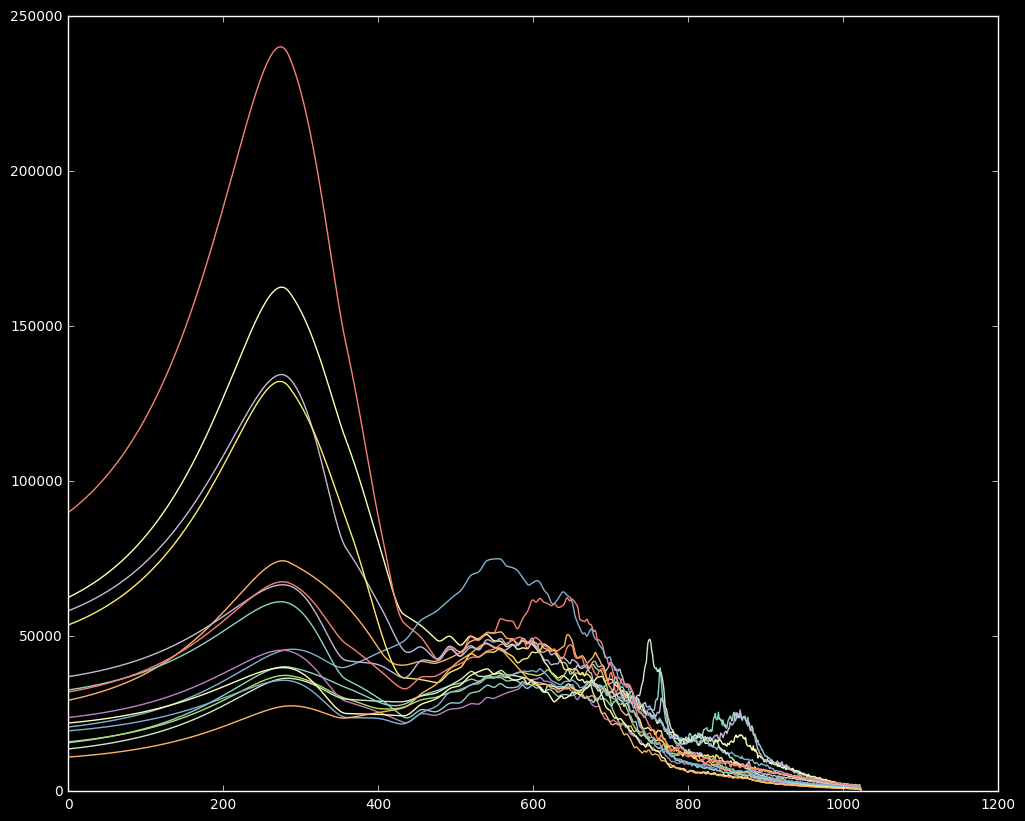

In [30]:
plot(data_a[0])
''

In [31]:
# Smooth the std?
# data_rs = signal.resample(data, 256, axis=1)
data_rs = signal.resample_poly(data_a, 4, 16, axis=1)
print(data_rs.shape)

(7949, 256, 16)


In [32]:
mean = np.mean(data_rs, axis=0)
std = np.std(data_rs, axis=0)
# gmean = np.mean(data)
# gstd = np.std(data)
# mean.shape, gstd.shape

In [33]:
zdata = (data_rs - mean) / (std*4)
# zdata = (data_rs) / (std*4)

zdata = np.nan_to_num(zdata)
zdata.shape

(7949, 256, 16)

''

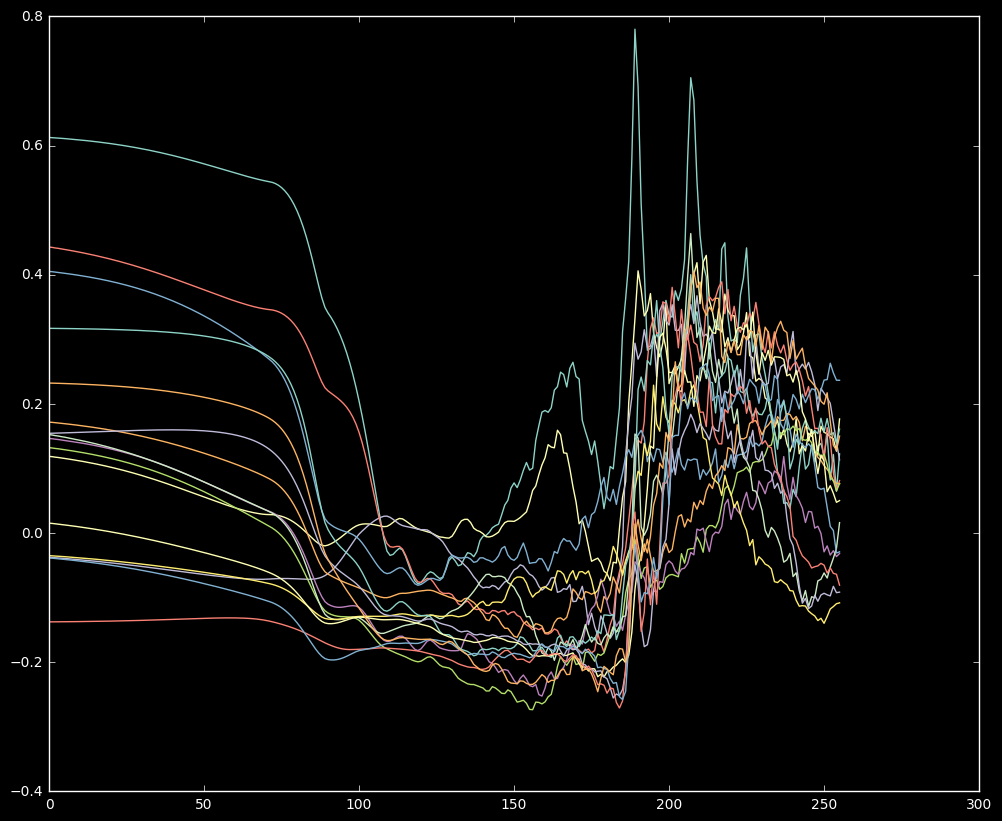

In [34]:
plt.plot(zdata[7000])
''

''

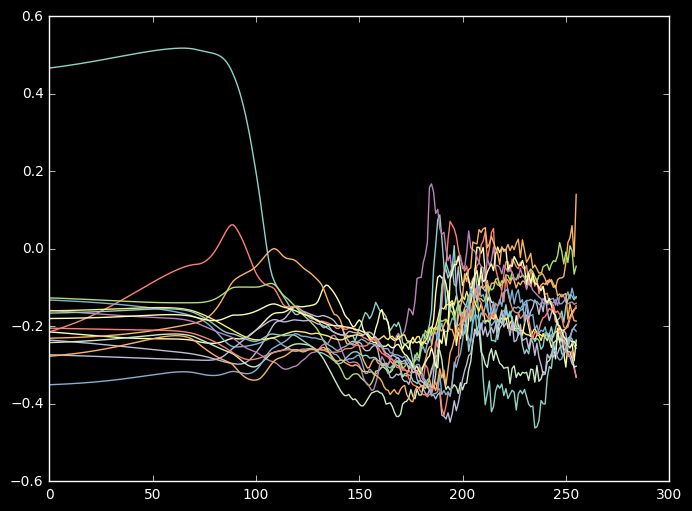

In [251]:
plt.plot(zdata[7080])
''

In [252]:
# data = dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_1001_0.mat')

In [253]:
data.shape

(7949, 1024, 16)

''

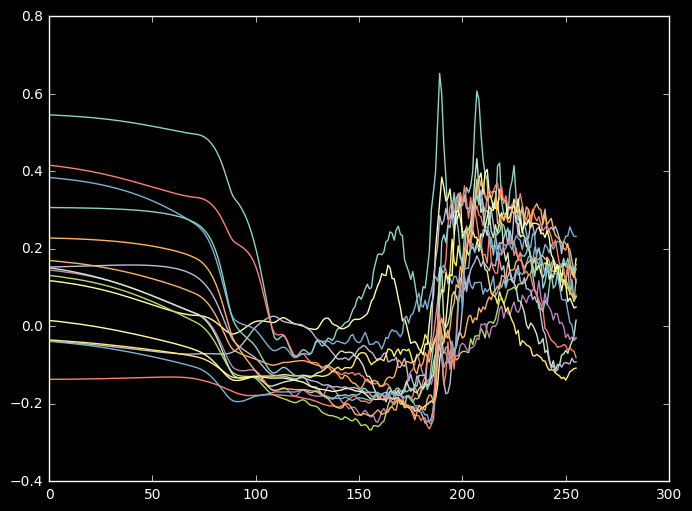

In [254]:
# ds = signal.resample(zdata[0:], 256, axis=1)
ds = zdata
ds = np.tanh(ds)
# ds = np.log(ds)
# ds = special.erf(ds)
plt.plot(ds[7000])
''

In [255]:
# ds2 = ds.reshape(ds.shape[0], -1)
# ds2 = ds.reshape(ds.shape[0]*16, -1)
# Serialize the electrodes so that there is 1 electrode per sample
ds2 = []
for i in range(16):
    ds2.append( ds[:,:,i])
ds2 = np.concatenate(ds2, axis=0)
ds2.shape

(127184, 256)

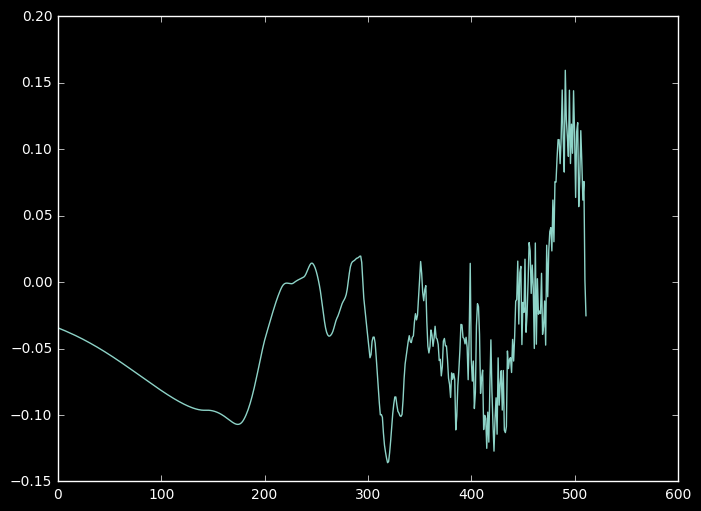

In [150]:
plt.plot(ds2[1000])

In [151]:
def convolino0():
    embedding_vecor_length = 32
    n_input_len=ds.shape[1]
    model = Sequential()
    # model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model.add(Convolution1D(nb_filter=64, filter_length=8, input_dim=1, 
                            input_length=n_input_len, border_mode='same', activation='relu'))
    model.add(MaxPooling1D(pool_length=2))
    model.add(LSTM(100))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

In [152]:
ds2.shape[1:]

(512,)

In [153]:
def autoencoder1(ds, compression_factor=8):
# compression_factor=20
    print('DS shape: {}'.format(ds.shape))
    in_dims = np.prod(ds.shape[1:])
    encoding_dim = int(in_dims//compression_factor)
    in_shape=ds[0].shape
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, in_shape, encoding_dim))
    
    # this is our input placeholder
    input_img = Input(shape=(in_dims,))
    # "encoded" is the encoded representation of the input
#     encoded = Dense(encoding_dim, activation='relu')(input_img)
    # Sparsity constraint
    encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.activity_l1(10e-5))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(in_dims, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)
    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.model_name = 'Autoencoder 1'
    return autoencoder, encoder, decoder
    
ae1, encoder, decoder = autoencoder1(ds2)
print(ae1.summary())

DS shape: (127184, 512)
Input Dims: 512, input shape: (512,), encoding dims: 64
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 512)           0                                            
____________________________________________________________________________________________________
dense_65 (Dense)                 (None, 64)            32832       input_25[0][0]                   
____________________________________________________________________________________________________
dense_66 (Dense)                 (None, 512)           33280       dense_65[0][0]                   
Total params: 66112
____________________________________________________________________________________________________
None


In [229]:
def autoencoder2(ds, compression_factor=8, input_noise=.2, dropout_p=0.3, activ='tanh', final_activ='sigmoid',
#                 loss='binary_crossentropy',
#                  loss='mse',
                 loss='msle'
#                  loss='kullback_leibler_divergence' # garbage
                ):
# compression_factor=20
    print('DS shape: {}'.format(ds.shape))
    in_dims = np.prod(ds.shape[1:])
    encoding_dim = int(in_dims//compression_factor)
    in_shape=ds[0].shape
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, in_shape, encoding_dim))
    sizes = [in_dims, encoding_dim*4, encoding_dim*2, encoding_dim]
    # this is our input placeholder
    input_img = Input(shape=(sizes[0],))
    encoded = GaussianNoise(input_noise)(input_img)
#     encoded = Dense(in_dims/4, activation=activ, activity_regularizer=regularizers.activity_l1(10e-5))(encoded)
    encoded = Dense(encoding_dim*4, activation=activ, activity_regularizer=regularizers.activity_l1(10e-5))(encoded)
#     encoded = Dense(encoding_dim*4, activation='sigmoid')(input_img)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_p)(encoded) #batch norm before dropout
#     encoded = Dense(encoding_dim*3, activation=activ)(encoded)
#     encoded = Dropout(dropout_p)(encoded)
    encoded = Dense(encoding_dim*2, activation=activ)(encoded)
    encoded = Dropout(dropout_p)(encoded)

    encoded = Dense(encoding_dim, activation=activ)(encoded)
    # Middle Noise
    encoded = GaussianNoise(0.02)(encoded)
    encoded = Dropout(0.05)(encoded) # output vector drop


    #DECODED LAYER
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(encoding_dim*2, activation=activ)(encoded)
#     decoded = Dropout(dropout_p)(decoded)
    decoded = Dense(encoding_dim*4, activation=activ)(decoded)
    decoded = Dropout(dropout_p)(decoded)
    decoded = Dense(in_dims, activation=final_activ)(decoded)
    

    #MODEL
    autoencoder = Model(input=input_img, output=decoded)


    #SEPERATE ENCODER MODEL
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))

    # retrieve the last layer of the autoencoder model
    decoder_layer0 = autoencoder.layers[-4]
    decoder_layer1 = autoencoder.layers[-3]
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer3 = autoencoder.layers[-1]
    # todo: make this into a dedicated unrolling function

    # create the decoder model - unrolling the model as we go
    decoder = Model(input=encoded_input, output=decoder_layer3(decoder_layer2(
                                                decoder_layer1(decoder_layer0( encoded_input)))))

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
    autoencoder.compile(optimizer='adadelta', loss=loss)

    autoencoder.model_name = 'Autoencoder 1'
    return autoencoder, encoder, decoder
    
ae2, encoder2, decoder2 = autoencoder2(ds2, activ='tanh', final_activ='linear')
print(ae2.summary())

DS shape: (127184, 512)
Input Dims: 512, input shape: (512,), encoding dims: 64
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_52 (InputLayer)            (None, 512)           0                                            
____________________________________________________________________________________________________
gaussiannoise_47 (GaussianNoise) (None, 512)           0           input_52[0][0]                   
____________________________________________________________________________________________________
dense_143 (Dense)                (None, 256)           131328      gaussiannoise_47[0][0]           
____________________________________________________________________________________________________
batchnormalization_25 (BatchNorma(None, 256)           512         dense_143[0][0]                  
___________

# Fitting the autoencoder

In [232]:
x_train = ds2
evals = []
for i in range(32):
    print('Process batch: {}'.format(i))
    x_test = ds2[i::15]
    ae2.fit(x_train, x_train, batch_size=256,shuffle=True,#validation_split=.75_,
            validation_data=(x_test, x_test),
                    nb_epoch=5               )
    proc_eval = ae2.evaluate(x_test, x_test)
    print('### Eval: {}'.format(proc_eval))
    evals.append(proc_eval)

Process batch: 0
Train on 127184 samples, validate on 8479 samples
Epoch 1/5
127184/127184 [==============================] - 8s - loss: 0.3000 - val_loss: 0.0176
Epoch 2/5
127184/127184 [==============================] - 8s - loss: 0.2972 - val_loss: 0.0113
Epoch 3/5
127184/127184 [==============================] - 8s - loss: 0.2945 - val_loss: 0.0085
Epoch 4/5
127184/127184 [==============================] - 8s - loss: 0.2909 - val_loss: 0.0069
Epoch 5/5
8448/8479 [============================>.] - ETA: 0s### Eval: 0.00513120044132
Process batch: 1
Train on 127184 samples, validate on 8479 samples
Epoch 1/5
127184/127184 [==============================] - 8s - loss: 0.2868 - val_loss: 0.0049
Epoch 2/5
127184/127184 [==============================] - 8s - loss: 0.2858 - val_loss: 0.0083
Epoch 3/5
127184/127184 [==============================] - 8s - loss: 0.2866 - val_loss: 0.0034
Epoch 4/5
127184/127184 [==============================] - 8s - loss: 0.2885 - val_loss: 0.0036
Epoch 5/5

KeyboardInterrupt: 

In [233]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder2.predict(x_train[:3000])
decoded_imgs = decoder2.predict(encoded_imgs)

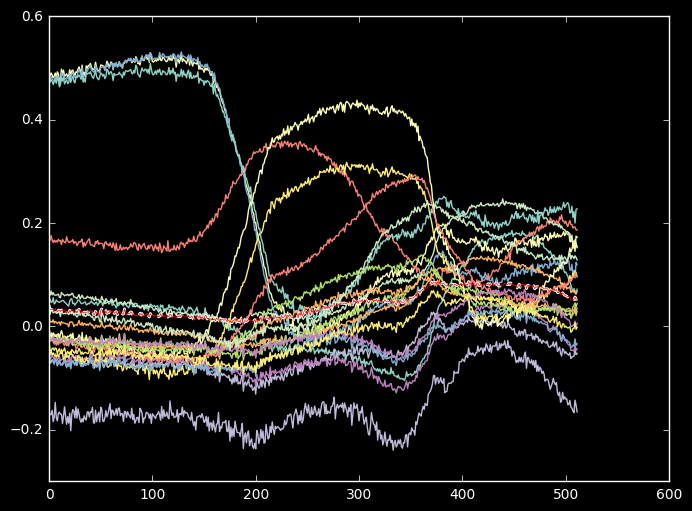

In [234]:
for i in range(20):
    plot(decoded_imgs[np.random.randint(0, decoded_imgs.shape[0])])
    
plot(np.mean(decoded_imgs, axis=0), 'w--', lw=2)
plot(np.mean(decoded_imgs, axis=0), 'r', lw=.5)

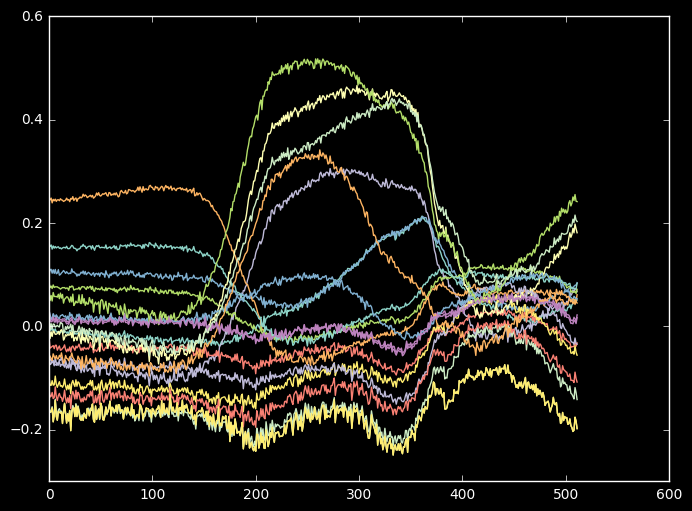

In [235]:
for i in range(1,20*17,17): 
    plt.plot(decoded_imgs[i])

[2001, 2018, 2035, 2052, 2069, 2086, 2103, 2120, 2137, 2154]


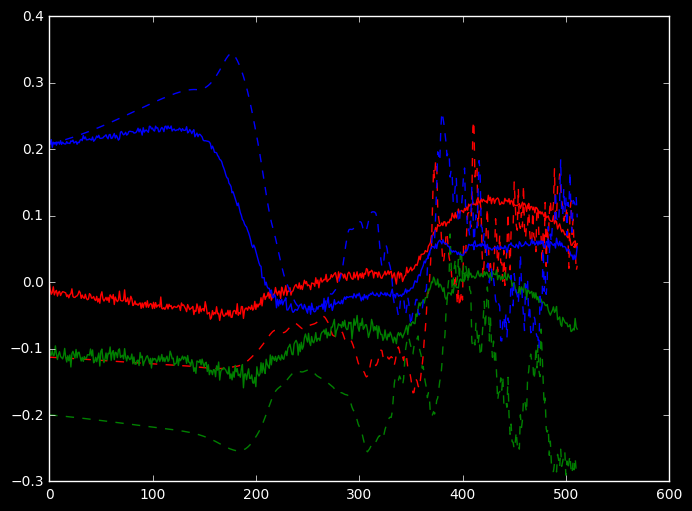

In [239]:
st = 2001
n = 10
nx = range(st,st+n*17,17)
print(nx)
c = ['r', 'g', 'b', 'm', 'c', 'y']
for i in range(3):
    j = nx[i]
    plt.plot(decoded_imgs[j], c[i])
    plt.plot(ds2[j], c[i]+'--')

In [256]:
tsne1 = manifold.TSNE(2, 30, n_iter=5000)

In [257]:
txdata1 = tsne1.fit_transform(ds2[::15])

In [279]:
tsne3 = manifold.TSNE(2, 30, n_iter=5000)

In [280]:
txdata3 = tsne3.fit_transform(ds2[::11])

In [260]:
txdata1.shape

(8479, 2)

In [272]:
6041. / ( ds2.shape[0] / 16) * (ds2.shape[0] / 15)

6443.024028179645

In [268]:
nZeros

5592

In [277]:
txdata2 = np.array(txdata1)

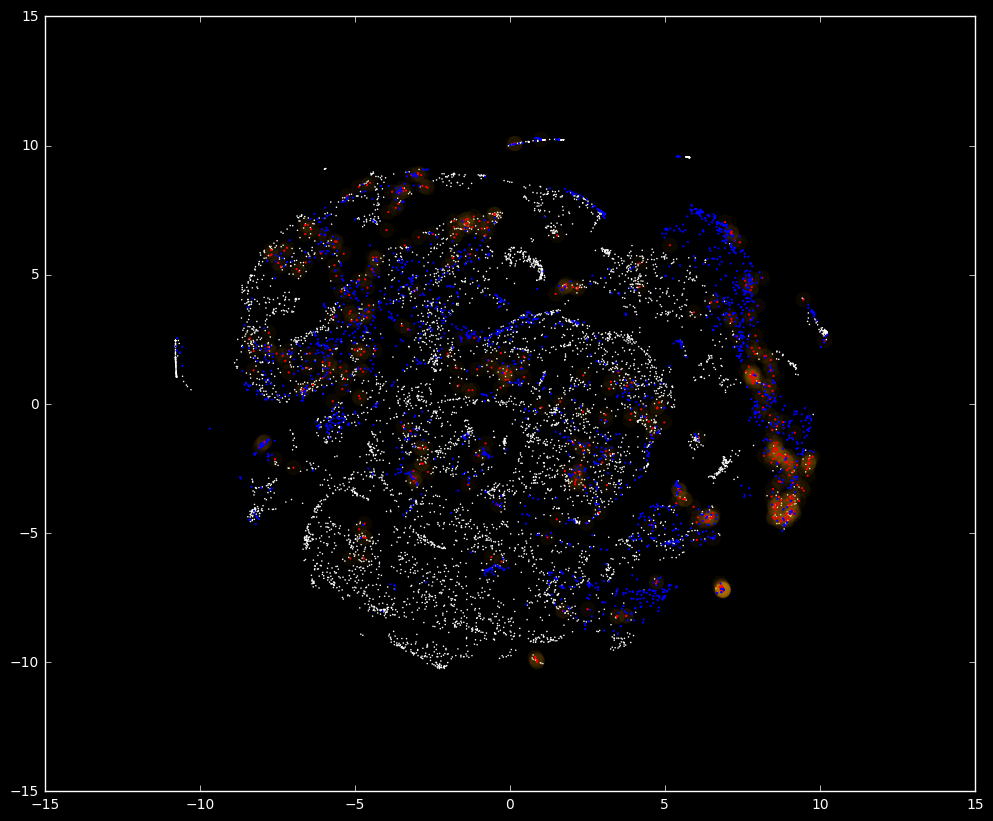

In [278]:
# plt.scatter(txdata1[:,0], txdata1[:,1])
nTrain = 6443
nZeros = 5964
cut = nZeros
nOnes = nTrain-nZeros

plt.scatter(txdata2[:cut,0], txdata2[:cut,1], c='w', s=5, marker='.',   edgecolors='none')
plt.scatter(txdata2[cut:nTrain,0], txdata2[cut:nTrain,1], c='orange', s=500, marker='.', edgecolors='none', alpha=0.05)
plt.scatter(txdata2[cut:nTrain,0], txdata2[cut:nTrain,1], c='r', s=10, marker='.', edgecolors='none')
plt.scatter(txdata2[nTrain:,0], txdata2[nTrain:,1], c='b', s=10, marker='.', edgecolors='none')

In [291]:
6041. / ( ds2.shape[0] / 16) * (ds2.shape[0] / 11)

8786.90909090909

/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


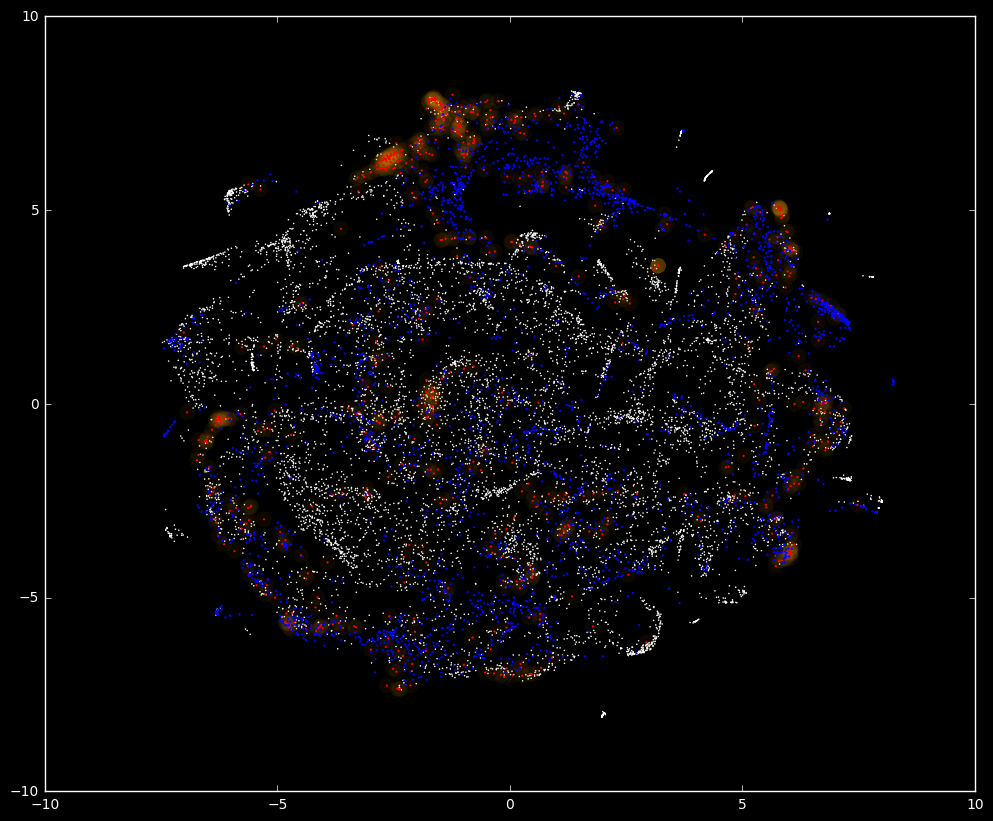

In [300]:
nTrain = int(6041 * txdata3.shape[0] / (ds2.shape[0] / 16) )
nZeros = int( nTrain * (5592/6041))
cut = nZeros
plt.scatter(txdata3[:cut,0], txdata3[:cut,1], c='w', s=5, marker='.',   edgecolors='none')
plt.scatter(txdata3[cut:nTrain,0], txdata3[cut:nTrain,1], c='orange', s=500, marker='.', edgecolors='none', alpha=0.05)
plt.scatter(txdata3[cut:nTrain,0], txdata3[cut:nTrain,1], c='r', s=10, marker='.', edgecolors='none')
plt.scatter(txdata3[nTrain:,0], txdata3[nTrain:,1], c='b', s=10, marker='.', edgecolors='none')

-5592

In [237]:
# ae2.save('ae_lf256_16.h5')

In [360]:
# encoder2.save('enc_lf256_16.h5')

In [364]:
encoded_imgs.shape
np.save('vec_enc_lf256_16_each', encoded_imgs)

In [101]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.dio import dataio
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [36]:
reload(dataio)
print(zdata.shape, Y.shape)
d0, d1, dt = dataio.separate_sets(zdata, Y)
print(d0.shape, d1.shape)
x,y = dataio.subdiv_and_shuffle(zdata, Y, resample='up', merge=False, shuffle=False) # let keras shuffle
# x = zdata
# y = Y

((6041, 1024, 16), (6041, 1))
((5592, 1024, 16), (449, 1024, 16))
new set:  (11429, 1024, 16)
label shapes:  (5592, 1) (5837, 1) 11429


In [113]:
print(x.shape, y.shape)

((11429, 1024, 16), (11429, 1))


In [114]:
np.mean(y, axis=0)

array([ 0.51071835])

In [115]:
y

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])

In [116]:
Yv = np.asarray(y == 1).ravel()
print(Yv)
Yv = np.stack([Yv, ~Yv], axis=1)
print(Yv.shape)
Yv = np.array(Yv, dtype=int)
print(Yv.shape)
np.mean(Yv[:,0])

[False False False ...,  True  True  True]
(11429, 2)
(11429, 2)


0.51071834806194771

In [117]:
print(x.shape, Yv.shape)

((11429, 1024, 16), (11429, 2))


In [ ]:
X_train = x
# X_train = x.reshape(-1, 256,1)
# X_train /= np.amax(X_train)
y_train = Yv # .reshape(-1, 2)
print(X_train.shape, y_train.shape)
ones_rate = np.mean(Yv[:,0])
class_weight= {0:1./(1-ones_rate), 1:1./ones_rate}
print(class_weight)
model.fit(X_train, y_train, nb_epoch=3, batch_size=64, shuffle=True, class_weight=class_weight, validation_split=0.2 )

((11429, 1024, 16), (11429, 2))
{0: 2.0438125894134478, 1: 1.9580263834161382}
Train on 9143 samples, validate on 2286 samples
Epoch 1/3
5696/9143 [=================>............] - ETA: 66s - loss: 1.2607 - acc: 0.6492

In [99]:
pr = model.predict_classes(X_train)

6041/6041 [==============================] - 51s    


In [100]:
np.sum(pr)

6041

In [151]:
pr.shape

(2344,)

In [157]:
np.mean(pr == y_train[:,1]) # MOMENT OF TRUUUUUTH!!!!!!

0.67875426621160406